# Rossman Store Sales Competition

This notebook contains a brief description of the analysis done and the final model.


## Table of Contents

1. [Data Processing](#data-pre-processing)
    * [Load raw sales data](#load-data)
    * [Add features: months, weeks](#features-months-weeks)
    * [Add features: beggining and end of month](#features-beginning-end-month)
    * [Clean data](#clean-data)
    * [Add features: store info](#features-store-info)
2. [Model Training](#model-training)
    * [Prepare train/test data](#prepare-train-test)
    * [Feature encoding](#feature-encoding)
    * [Feature scaling](#feature-scaling)
    * [Models Selection](#model-selection)
    * [Processing pipeline](#processing-pipeline)
    * [Final training](#final-training)
    * [Saving the model](#saving-model)
4. [Model Evaluation](#model-evaluation)
    * [Test Score](#test-score)
    * [Prediction and Error Analysis](#prediction-error-analysis)
    * [Feature Importance](#feature-importance)


## Data Processing <a class="anchor" id="data-pre-processing"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']=150
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

# Load scripts from parent path
import sys, os
sys.path.insert(0, os.path.abspath('..'))

# Ignore some future warnings triggered when training
import warnings
warnings.filterwarnings(action="ignore", category=FutureWarning)

### Load raw sales data <a class="anchor" id="load-data"></a>

This table contains the raw daily sales by Rossmann store.

The target column is:
  - `Sales`: The total sum of sales for this store and date

The features columns are:
  - `Date`: The date of the sales record
  - `Store`: An ID of the store
  - `DayOfWeek`: The day of the week, given as an integer, ranging from Monday (0) to Sunday (6).
  - `Customers`: The number of customers for this store and date. We will drop this, as this information is not available for the future.
  - `Open`: Whether the store was open on this date: 0 = closed, 1 = open
  - `Promo`: Whether the store ran a promotion on this date.
  - `StateHoliday`: Whether this date was a state holiday.
  - `SchoolHoliday`: Whether this date was a school holiday.

The training data includes data for one and a half years, from 2013-01-01 until 2014-07-31.

The holdout (test) period is the following 6 months, from 2014-08-01 to 2015-07-31.


In [2]:
import scripts.processing as scr

train_raw = scr.load_train_data()
train_raw.head()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,2013-01-01,1115.0,2.0,0.0,0.0,0.0,0.0,a,1.0
1,2013-01-01,379.0,2.0,0.0,0.0,0.0,0.0,a,1.0
2,2013-01-01,378.0,2.0,0.0,0.0,0.0,0.0,a,1.0
3,2013-01-01,377.0,2.0,0.0,0.0,0.0,0.0,a,1.0
4,2013-01-01,376.0,2.0,0.0,0.0,0.0,0.0,a,1.0


**Plot sales**

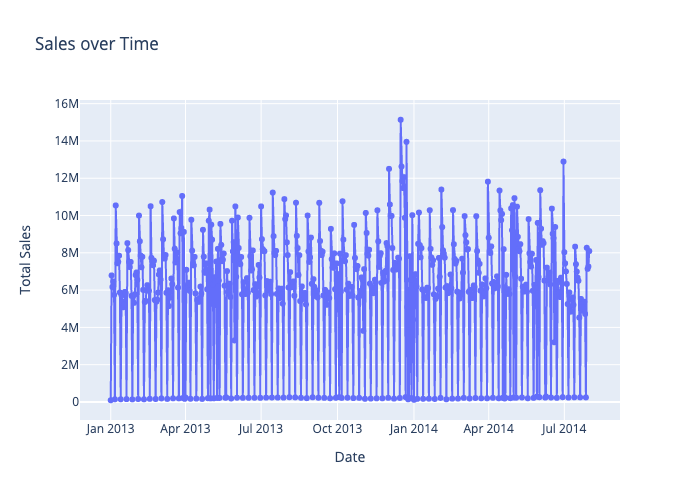

In [3]:
sales = train_raw.groupby(by='Date').agg({'Sales': 'sum'}).reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=sales['Date'], y=sales['Sales'],
                    mode='lines+markers',
                    name='actual'))
fig.update_layout(title='Sales over Time',
                   xaxis_title='Date',
                   yaxis_title='Total Sales')
fig.show('png')

### Add features: months, weeks <a class="anchor" id="features-months-weeks"></a>

The `Date`-column in itself is not informative, as our prediction should
extrapolate in the future. However, features of the date can be extracted.

To captures seasonal trends in sales, we added the features:
- `month`: The month of the year.
- `week`: The week of the year.

Note: The functions used here (such as `add_week_month_info`) are also implemented in `scripts.processing`, we
repeat them here just for illustration.

In [4]:
def add_week_month_info(train):
    """
    Add week and month information as another column to the features.
    """
    train.loc[:,'week'] = train.loc[:,'Date'].dt.isocalendar().week.astype(int)
    train.loc[:,'month'] = train.loc[:,'Date'].dt.month
    return train

train = add_week_month_info(train_raw)
train.loc[:, ['week', 'month']].head()

,week,month
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


### Add features: Beggining and end of month signifiers <a class="anchor" id="features-beginning-end-month"></a>

After our first round of modeling, we found that the errors/residuals of our models were very high towards the beginning and end of months (see analysis in the end of this notebook).

This could indicate that sales patterns are different at the beginning and
end of months (for example if people receive their paycheck with
some regularity).

To enable our model to learn these patterns, we decided to add features that
signify the beginning and end of months:
- `beginning_of_month`: Indicates whether the date is towards the *beginning* of the month, ranging from 0 (no) to 1 (yes).
- `end_of_month`: Indicates whether the date is towards the *end* of the month, ranging from 0 (no) to 1 (yes).


In [5]:
def add_beginning_end_month(train):
    """
    Add features that represent the beginning and end of months.
    """
    def get_feature_end_month(day_of_month):
        return (day_of_month/31)**4

    def get_feature_beginning_month(day_of_month):
        return ((31-day_of_month)/31)**4

    # get_feature_end_month(33)
    train.loc[:, 'end_of_month'] = train.loc[:, 'Date'].dt.day.apply(get_feature_end_month)
    train.loc[:, 'beginning_of_month'] = train.loc[:, 'Date'].dt.day.apply(get_feature_beginning_month)
    return train

train = add_beginning_end_month(train)
train.loc[:, ['Date', 'end_of_month', 'beginning_of_month']].head()

,Date,end_of_month,beginning_of_month
0,2013-01-01,0.000001,0.877078
1,2013-01-01,0.000001,0.877078
2,2013-01-01,0.000001,0.877078
3,2013-01-01,0.000001,0.877078
4,2013-01-01,0.000001,0.877078


**Visualization of beginning/end of month features**

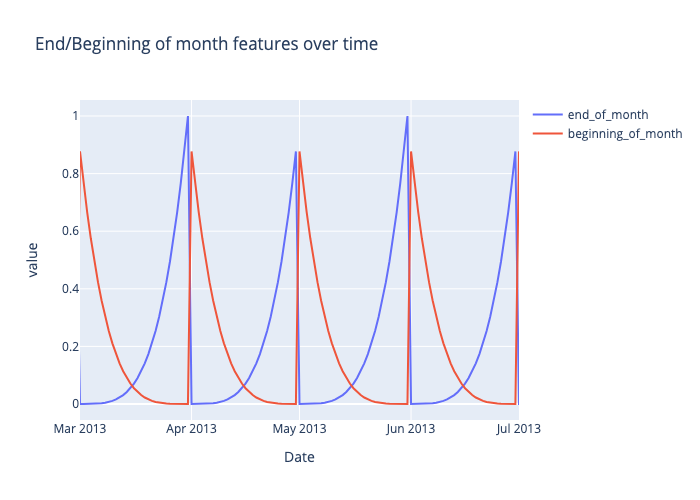

In [6]:
month_features = train.groupby(by='Date').agg({'end_of_month': 'first', 'beginning_of_month': 'first'}).reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=month_features['Date'], y=month_features['end_of_month'],
                    mode='lines',
                    name='end_of_month'))

fig.add_trace(go.Scatter(x=month_features['Date'], y=month_features['beginning_of_month'],
                    mode='lines',
                    name='beginning_of_month'))
                    
fig.update_layout(title='End/Beginning of month features over time',
                   xaxis_title='Date',
                   yaxis_title='value',
                   xaxis_range=[datetime(2013, 3, 1),
                               datetime(2013, 7, 1)])

fig.show('png')

### Clean data <a class="anchor" id="clean-data"></a>

We do some small data cleaning steps:
- Drop the `Customers` column, as this info will not be available in the future.
- Remove rows with sales that are null or 0.
- Drop the `Open` column - stores that have non-zero sales are open.
- Remove observations with null values in any feature.
- etc.

In [7]:
def clean_data(train_raw, drop_null=True, drop_date=True):
    """ Some common basic data processing. 
    
    This function
     - Encodes the state holidays
     - Drops unneeded columns (Customers, Open, Date)
     - Removes all rows where 'Sales' were 0
     - Removes all rows with nan values
    """
    train = train_raw.copy()
    train.loc[:, 'StateHoliday'] = train.loc[:, 'StateHoliday'].replace(to_replace='0', value='d')
    train.loc[:, 'StateHoliday'].replace({'a':1, 'b':2, 'c':3, 'd':4}, inplace = True)

    # Drop customers, open and Date
    train = train.drop(["Customers", "Open"], axis=1)
    if drop_date:
        train = train.drop("Date", axis=1)

    # Drop all where sales are nan or 0
    if 'Sales' in train.columns:
        train = train.dropna(axis=0, how='any', subset=['Sales'])
        train = train.loc[train.loc[:, 'Sales']!=0, :]

    # Drop all null value
    if drop_null:
        train = train.dropna(axis=0, how='any')

    return train

train = clean_data(train)

### Add features: Store info <a class="anchor" id="features-store-info"></a>

Some additional information on the stores was made available in the
file `data/store.csv`.

We combined this with the sales information and calculated some additional features.

(The full details are given in the notebook `util_extract_store_info`)

We added the following features:
 - `Store`: The ID of the store, for mapping to the sales data.
 - `StoreType`: The type of store, differing between four models, a, b, c, d.
 - `Assortment`: The type of goods that the store is carrying, a = basic, b = extra, c = extended.
 - `CompetitionDistance`: The distance to the nearest competing store, in meters.
 - `month`: The month for which average sales and customers were calculated.
 - `Store_Sales_mean`: The mean sales for this store and month.
 - `Store_Customers_mean`: The mean customers for this store and month.

In [8]:
store_info = pd.read_csv("../data/store_info.csv")
store_info.head()

,Store,StoreType,Assortment,CompetitionDistance,month,Store_Sales_mean,Store_Customers_mean
0,1,c,a,1270.0,1,3926.966102,487.442623
1,1,c,a,1270.0,2,4175.722222,508.716981
2,1,c,a,1270.0,3,4273.250000,517.338983
3,1,c,a,1270.0,4,3912.875000,471.948276
4,1,c,a,1270.0,5,3784.733333,454.762712


Merge the store info onto the sales table.

In [9]:
def add_store_info(train):
    """ Add the store info to sales data.

    Merges the store info on the train table and returns the combined table
    """
    # Load store info
    store_info = pd.read_csv("../data/store_info.csv")
    # Merge store info onto train data
    train = pd.merge(left=train, right=store_info, how='left', on=['Store', 'month'])
    return train

train = add_store_info(train)
train.loc[:, ['StoreType', 'Assortment',
              'CompetitionDistance', 'Store_Sales_mean',
              'Store_Customers_mean']].head()

,StoreType,Assortment,CompetitionDistance,Store_Sales_mean,Store_Customers_mean
0,b,b,900.0,4139.474576,1153.783333
1,b,a,90.0,12845.896552,2384.271186
2,b,b,590.0,3725.649123,888.627119
3,b,a,1260.0,7079.150000,1010.583333
4,a,c,18160.0,2260.783333,333.610169


## Model Training <a class="anchor" id="model-training"></a>

### Prepare train/test data <a class="anchor" id="prepare-train-test"></a>

Now we're preparing the final dataset for the training.

The target label is `Sales`.

The features include all the other columns in the dataset.



In [10]:
# Split label and features
X = train.copy(deep=True).drop(columns=["Sales"])
y = train.loc[:, "Sales"]

# Make train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,week,month,end_of_month,beginning_of_month,StoreType,Assortment,CompetitionDistance,Store_Sales_mean,Store_Customers_mean
0,353.0,2.0,0.0,1.0,1.0,1,1,0.000001,0.877078,b,b,900.0,4139.474576,1153.783333
1,335.0,2.0,0.0,1.0,1.0,1,1,0.000001,0.877078,b,a,90.0,12845.896552,2384.271186
2,512.0,2.0,0.0,1.0,1.0,1,1,0.000001,0.877078,b,b,590.0,3725.649123,888.627119
3,494.0,2.0,0.0,1.0,1.0,1,1,0.000001,0.877078,b,a,1260.0,7079.150000,1010.583333
4,530.0,2.0,0.0,1.0,1.0,1,1,0.000001,0.877078,a,c,18160.0,2260.783333,333.610169


### Feature Encoding <a class="anchor" id="feature-encoding"></a>

We originally used one-hot encoding for certain features such as Assortment type, State holiday, Store type, ... but the final score for target encoding was better. Therefore, we chose to target encode any feature that needs to be encoded.

In [11]:
import category_encoders as ce
target_encode  = ce.TargetEncoder()

### Feature Scaling <a class="anchor" id="feature-scaling"></a>
We scaled the features, to have the same range. This step has a higher importance, when using linear regression models.

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

### Model Selection <a class="anchor" id="models"></a>

We used various different models, including
 - Naive Mean Estimator
 - Linear Regression
 - Random Forest Regressor
 - Gradient Boosted Trees.

We found that the best performing model was a Gradient Boosted Tree (GBT),
which we trained using the `LightGBM` library.

Here, we show the training of this final model.

You can find details on the training of the other models in the notebooks:
 - [notebooks/2_simple_models](notebooks/2_simple_models.ipynb)
 - [notebooks/3_advanced_models](notebooks/3_advanced_models.ipynb)

We also performed a hyperparameter optimization of the GBT model. Here,
we only show the model with the final parameters. You can
find the details of the optimization in the notebook [notebooks/3_advanced_models](notebooks/3_advanced_models.ipynb).

In [13]:
from lightgbm import LGBMRegressor
# Create GBT model with best parameters (from hyperparameter optimization)
model = LGBMRegressor(
    n_estimators=500,
    max_depth=25,
    num_leaves=80
)

### Train the pipeline <a class="anchor" id="processing-pipeline"></a>
We created a pipeline consisting of different processing steps: encoding, scaling and modeling

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
pipe = Pipeline(steps=[ 
                ('target_encode', target_encode),
                ('scaler',scaler),
                ('model',model)])      

pipe.fit(X_train, y_train)

Pipeline(steps=[('target_encode',
                 TargetEncoder(cols=['StoreType', 'Assortment'])),
                ('scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(max_depth=25, n_estimators=500, num_leaves=80))])

### Model Performance
Finally, we evaluated the error using on the validation data set.

In [16]:
from scripts.processing import metric
y_pred_train = pipe.predict(X_train)
y_pred = pipe.predict(X_test)
rmspe = metric(y_test.values, y_pred)                     
print(f"RMSPE metric on test set: {rmspe:.2f}")

RMSPE metric on test set: 11.60


### Final Training <a class="anchor" id="final-training"></a>

Finally, we used the best model and trained it once again on the total data to create the final model

In [18]:
pipe.fit(X, y)

Pipeline(steps=[('target_encode',
                 TargetEncoder(cols=['StoreType', 'Assortment'])),
                ('scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(max_depth=25, n_estimators=500, num_leaves=80))])

### Saving the model <a class="anchor" id="saving-model"></a>

We save the trained model so that it can be reused later.

In [19]:
#from scripts.pipeline import save_pipeline
#save_pipeline(pipeline=pipe, name='LGBM_hyperparam_optim_3')

## Model Evaluation <a class="anchor" id="model-evaluation"></a>

We now load the final model, with was a Gradient Boosted Tree classifier.

In [20]:
from scripts.pipeline import load_pipeline
pipe = load_pipeline(name='LGBM_hyperparam_optim_3')
y_pred = pipe.predict(X)

 - Loading pipeline "LGBM_hyperparam_optim_3" at:
../data/trained_pipelines/pipeline_LGBM_hyperparam_optim_3.p


### Score on test set <a class="anchor" id="test-score"></a>

Note: This is not accurate anymore because the final 
model was also trained on the test set.

(The accuracte final score is on the Kaggle Holdout set)

In [21]:
from scripts.processing import metric
y_pred = pipe.predict(X_test)
error_regLGBM = metric(y_test.values, y_pred)
print(f"RMSPE metric on test set: {error_regLGBM:.2f}")

RMSPE metric on test set: 10.05


### Prediction and Error analysis <a class="anchor" id="prediction-error-analysis"></a>

To better evaluate the model, we compare the daily sales
numbers predicted by our model and the actual daily sales.

In [23]:
def metric_not_summed(preds, actuals):
    """ The RMSPE metric per observation """
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * (actuals - preds) / actuals

# Get predictions of the model over the full range of data.
y_pred = pipe.predict(X)

# Load the dates from the data
train_raw = scr.load_train_data()
dates = pd.DataFrame(scr.process_data(train_raw, drop_null=True, drop_date=False).loc[:, 'Date'])

# Merge predicted and actual values
result = dates.copy()
result = result.reset_index() #added step to solve the problem with keys and nan values in y_actual

result.loc[:, 'pred'] = y_pred  
result.loc[:, 'actual'] = y

# Sum up result by date
result = result.groupby(by='Date').sum().reset_index()

# Calculate the error
result.loc[:, 'error'] = metric_not_summed(result.loc[:, 'pred'].values, result.loc[:, 'actual'].values)
result.loc[:, 'error_abs'] = np.abs(result.loc[:, 'error'])
result.head()

,Date,index,pred,actual,error,error_abs
0,2013-01-01,7453,1.247358e+05,87980.0,-41.777470,41.777470
1,2013-01-02,1538235,5.706822e+06,5707185.0,0.006356,0.006356
2,2013-01-03,2521226,5.233531e+06,5177894.0,-1.074515,1.074515
3,2013-01-04,3657192,5.629987e+06,5627268.0,-0.048311,0.048311
4,2013-01-05,4645127,5.017485e+06,4960593.0,-1.146888,1.146888


#### Compare predicted sales vs. actual

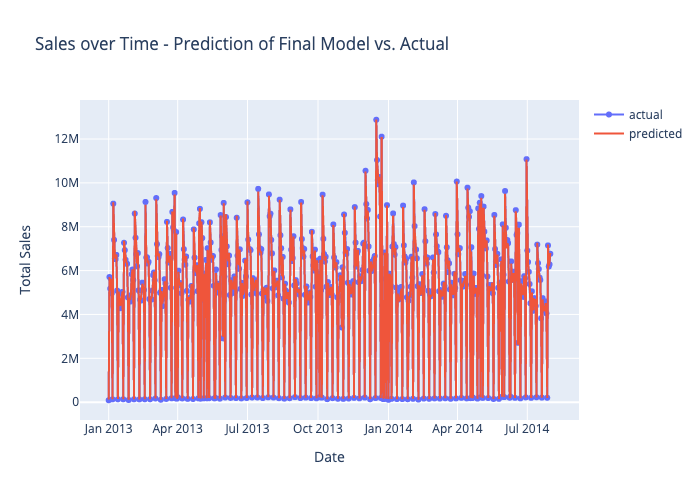

In [24]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=result['Date'], y=result['actual'],
                    mode='lines+markers',
                    name='actual'))

fig.add_trace(go.Scatter(x=result['Date'], y=result['pred'],
                    mode='lines',
                    name='predicted'))
# Edit the layout
fig.update_layout(title='Sales over Time - Prediction of Final Model vs. Actual',
                   xaxis_title='Date',
                   yaxis_title='Total Sales')
fig.show('png')

#### Plot errors/residuals

During training, we analyzed the errors/residuals to see which
dates the model got wrong, and adpated our features accordingly.

At the moment there are still some date ranges with larger errors,
for example around new years. Further analysis here should improve the model performance.

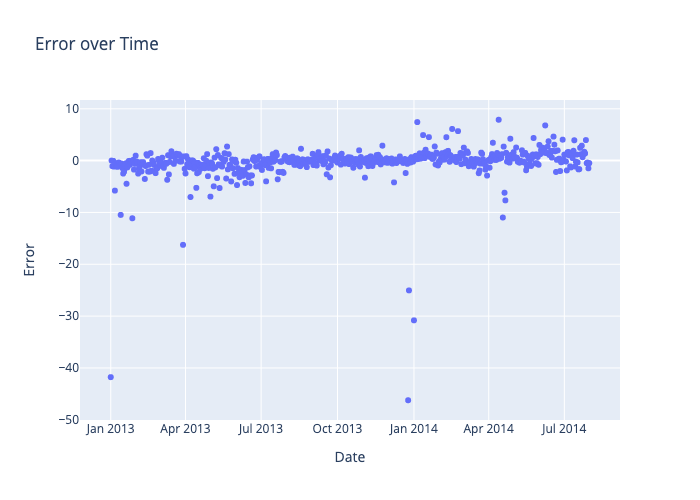

In [25]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=result['Date'], y=result['error'],
                    mode='markers',
                    name='actual'))

fig.update_layout(title='Error over Time',
                   xaxis_title='Date',
                   yaxis_title='Error')

fig.show('png')

#### Feature importance <a class="anchor" id="feature-importance"></a>

We also analyzed the importance of features in the final model.

Some interesting insights:
  - It appears that the specific store is a very important predictor, as it
  features in many variables (`Store`, `CompetitionDistance`, etc.). Some further analysis of the stores should be helpful here.
  - The `end_of_month` feature ranks quite high, which indicates that it actually improved model performace. `beginning_of_month` is less important.
  - The holiday-encoding variables `SchoolHoliday` and `StateHoliday` are very low in importance. However,
  from looking at the sales we know that holidays are important, for example in the elevated sales in December. 
  It might be that these existing variables do not capture these features well. One problem might be that they only indicate the date of the holiday itself, while sales are distorted in a wider period around the holiday. Adding more time-dependent features might help here.


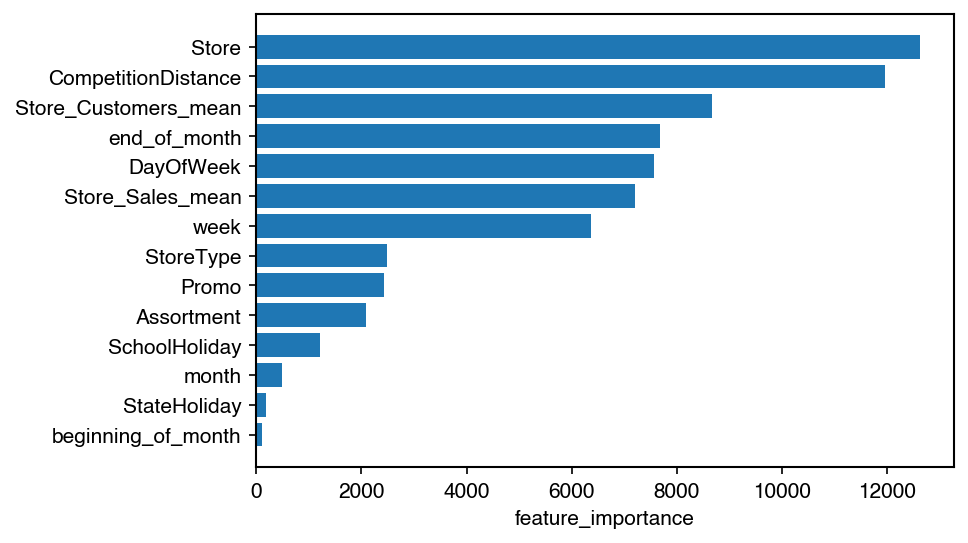

In [26]:
model = pipe['model']
importances = pd.DataFrame({'feature': pipe[1].get_feature_names_out(), 'importance': model.feature_importances_})
importances = importances.sort_values(by='importance', ascending=True)
plt.barh(y=importances['feature'], width=importances['importance'])
plt.xlabel("feature_importance")
plt.show()